# APPROCHE SUPERVISEE DE PROPOSITION DE TAGS

### RESUME

Ce notebook met en œuvre une approche supervisée pour proposer des tags pertinents aux questions posées sur Stack Overflow. Nous intégrons le tracking d'expérimentations via MLFlow et assurons un stockage centralisé des modèles pour évaluer et sélectionner la meilleure approche.

### PLAN


Introduction à MLFlow

- Choix et mise en œuvre de différentes approches de modélisation supervisée.

- Utilisation de MLFlow pour suivre les performances des modèles à chaque itération.


- Analyse comparative des performances des différents modèles en fonction de métriques définies.


- Stockage centralisé des modèles sélectionnés pour une utilisation ultérieure.

Documentation et conclusion

### Importation des libraries

In [94]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [137]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import time
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch
import warnings
import os
from datetime import datetime
import re
from sklearn.metrics import  f1_score, accuracy_score
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModelForSequenceClassification, AdamW
import warnings

# Ignorer les avertissements de convergence de sklearn
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option("display.max_columns", None)

### Chargement des données

In [136]:
df = pd.read_csv(r'C:\Users\amous\OneDrive\Desktop\projet5\dataN.csv', sep=';')

In [138]:
df

,Title,Body,Tags,Text
0,"['client', 'side', 'image', 'processing']","['we', 'building', 'a', 'web', 'based', 'application', 'that', 'requires', 'heavy', 'image', 'processing', 'we', 'like', 'this', 'processing', 'load', 'to', 'be', 'on', 'the', 'client', 'as', 'much', 'as', 'possible', 'and', 'we', 'like', 'to', 'support', 'as', 'much', 'platforms', 'even', 'mobiles', 'as', 'much', 'as', 'possible', 'yeah', 'i', 'know', 'wishful', 'thinking', 'here', 'the', 'info', 'image', 'processing', 'is', 'rasterization', 'from', 'some', 'data', 'think', 'like', 'creating', 'a', 'png', 'image', 'from', 'a', 'pdf', 'file', 'we', 'don', 'have', 'a', 'lot', 'of', 'server', 'power', 'so', 'client', 'side', 'processing', 'is', 'a', 'bit', 'of', 'a', 'must', 'so', 'we', 'considering', 'flash', 'most', 'widespread', 'but', 'from', 'what', 'i', 'read', 'has', 'lackluster', 'development', 'tools', 'and', 'no', 'iphone', 'ipad', 'support', 'for', 'now', 'silverlight', 'allows', 'us', 'to', 'use', 'net', 'clr', 'so', 'a', 'big', '++', 'a', 'lot', 'of', 'code', 'is', 'in', 'net', 'but', 'is', 'not', 'supported', 'for', 'most', 'mobiles', 'rumored', 'android', 'support', 'in', 'the', 'future', '+', 'javascript', 'probably', 'the', 'most', 'portable', 'option', 'the', 'problem', 'is', 'having', 'to', 'rewrite', 'all', 'that', 'image', 'processing', 'code', 'in', 'javascript', 'any', 'thoughts', 'or', 'architectures', 'that', 'might', 'help', 'clarification', 'i', 'don', 'need', 'further', 'ideas', 'on', 'what', 'libraries', 'are', 'available', 'for', 'silverlight', 'and', 'javascript', 'my', 'dilemma', 'is', 'choosing', 'silverlight', 'means', 'no', 'support', 'for', 'most', 'mobiles', 'choosing', 'flash', 'means', 'we', 'have', 'to', 'redevelop', 'most', 'of', 'our', 'code', 'and', 'no', 'iphone', 'ipad', 'support', '+', 'javascript', 'we', 'have', 'to', 'redevelop', 'most', 'of', 'our', 'code', 'and', 'not', 'fully', 'supported', 'yet', 'in', 'all', 'browsers', 'choosing', 'two', 'silverlight', '+', 'flash', 'will', 'be', 'too', 'costly', 'any', 'out', 'of', 'the', 'box', 'or', 'bright', 'ideas', 'alternatives', 'i', 'might', 'be', 'missing']","['html', 'flash', 'silverlight', 'image-processing', 'ria']",[client side image processing we building a web based application that requires heavy image processing we like this processing load to be on the client as much as possible and we like to support as much platforms even mobiles as much as possible yeah i know wishful thinking here the info image processing is rasterization from some data think like creating a png image from a pdf file we don have a lot of server power so client side processing is a bit of a must so we considering flash most widespread but from what i read has lackluster development tools and no iphone ipad support for now silverlight allows us to use net clr so a big ++ a lot of code is in net but is not supported for most mobiles rumored android support in the future + javascript probably the most portable option the problem is having to rewrite all that image processing code in javascript any thoughts or architectures that might help clarification i don need further ideas on what libraries are available for silverlight and javascript my dilemma is choosing silverlight means no support for most mobiles choosing flash means we have to redevelop most of our code and no iphone ipad support + javascript we have to redevelop most of our code and not fully supported yet in all browsers choosing two silverlight + flash will be too costly any out of the box or bright ideas alternatives i might be missing ]
1,"['c++', 'unix', 'open', 'a', 'text', 'file', 'with', 'the', 'default', 'editor']","['the', 'question', 'is', 'above', 'and', 'my', 'google', 'search', 'wasn', 'succesfull', 'i', 'guess', 'i', 'need', 'to', 'get', 'the', 'default', 'editor', 'and', 'then', 'use', 'system', 'editor', 'file', 'txt', 'how', 'could', 'i', 'get', 'the', 'default', 'editor', 'edit', 'i', 'don', 'know', 'why', '

In [97]:
# On convertit en liste car ça se perd quand on save en csv, puis on passe de liste à texte
import ast
df['text'] = df['Body'].map(lambda X: ast.literal_eval(X)).map(lambda X: ' '.join(X))

In [98]:
df['text'].iloc[0]

'we building a web based application that requires heavy image processing we like this processing load to be on the client as much as possible and we like to support as much platforms even mobiles as much as possible yeah i know wishful thinking here the info image processing is rasterization from some data think like creating a png image from a pdf file we don have a lot of server power so client side processing is a bit of a must so we considering flash most widespread but from what i read has lackluster development tools and no iphone ipad support for now silverlight allows us to use net clr so a big ++ a lot of code is in net but is not supported for most mobiles rumored android support in the future + javascript probably the most portable option the problem is having to rewrite all that image processing code in javascript any thoughts or architectures that might help clarification i don need further ideas on what libraries are available for silverlight and javascript my dilemma is

In [99]:
# On convertit en liste car ça se perd quand on save en csv
df['Tags'] = df['Tags'].map(lambda X: ast.literal_eval(X))

In [100]:
df

,Title,Body,Tags,Text,text
0,"['client', 'side', 'image', 'processing']","['we', 'building', 'a', 'web', 'based', 'application', 'that', 'requires', 'heavy', 'image', 'processing', 'we', 'like', 'this', 'processing', 'load', 'to', 'be', 'on', 'the', 'client', 'as', 'much', 'as', 'possible', 'and', 'we', 'like', 'to', 'support', 'as', 'much', 'platforms', 'even', 'mobiles', 'as', 'much', 'as', 'possible', 'yeah', 'i', 'know', 'wishful', 'thinking', 'here', 'the', 'info', 'image', 'processing', 'is', 'rasterization', 'from', 'some', 'data', 'think', 'like', 'creating', 'a', 'png', 'image', 'from', 'a', 'pdf', 'file', 'we', 'don', 'have', 'a', 'lot', 'of', 'server', 'power', 'so', 'client', 'side', 'processing', 'is', 'a', 'bit', 'of', 'a', 'must', 'so', 'we', 'considering', 'flash', 'most', 'widespread', 'but', 'from', 'what', 'i', 'read', 'has', 'lackluster', 'development', 'tools', 'and', 'no', 'iphone', 'ipad', 'support', 'for', 'now', 'silverlight', 'allows', 'us', 'to', 'use', 'net', 'clr', 'so', 'a', 'big', '++', 'a', 'lot', 'of', 'code', 'is', 'in', 'net', 'but', 'is', 'not', 'supported', 'for', 'most', 'mobiles', 'rumored', 'android', 'support', 'in', 'the', 'future', '+', 'javascript', 'probably', 'the', 'most', 'portable', 'option', 'the', 'problem', 'is', 'having', 'to', 'rewrite', 'all', 'that', 'image', 'processing', 'code', 'in', 'javascript', 'any', 'thoughts', 'or', 'architectures', 'that', 'might', 'help', 'clarification', 'i', 'don', 'need', 'further', 'ideas', 'on', 'what', 'libraries', 'are', 'available', 'for', 'silverlight', 'and', 'javascript', 'my', 'dilemma', 'is', 'choosing', 'silverlight', 'means', 'no', 'support', 'for', 'most', 'mobiles', 'choosing', 'flash', 'means', 'we', 'have', 'to', 'redevelop', 'most', 'of', 'our', 'code', 'and', 'no', 'iphone', 'ipad', 'support', '+', 'javascript', 'we', 'have', 'to', 'redevelop', 'most', 'of', 'our', 'code', 'and', 'not', 'fully', 'supported', 'yet', 'in', 'all', 'browsers', 'choosing', 'two', 'silverlight', '+', 'flash', 'will', 'be', 'too', 'costly', 'any', 'out', 'of', 'the', 'box', 'or', 'bright', 'ideas', 'alternatives', 'i', 'might', 'be', 'missing']","[html, flash, silverlight, image-processing, ria]",[client side image processing we building a web based application that requires heavy image processing we like this processing load to be on the client as much as possible and we like to support as much platforms even mobiles as much as possible yeah i know wishful thinking here the info image processing is rasterization from some data think like creating a png image from a pdf file we don have a lot of server power so client side processing is a bit of a must so we considering flash most widespread but from what i read has lackluster development tools and no iphone ipad support for now silverlight allows us to use net clr so a big ++ a lot of code is in net but is not supported for most mobiles rumored android support in the future + javascript probably the most portable option the problem is having to rewrite all that image processing code in javascript any thoughts or architectures that might help clarification i don need further ideas on what libraries are available for silverlight and javascript my dilemma is choosing silverlight means no support for most mobiles choosing flash means we have to redevelop most of our code and no iphone ipad support + javascript we have to redevelop most of our code and not fully supported yet in all browsers choosing two silverlight + flash will be too costly any out of the box or bright ideas alternatives i might be missing ],we building a web based application that requires heavy image processing we like this processing load to be on the client as much as possible and we like to support as much platforms even mobiles as much as possible yeah i know wishful thinking here the info image processing is rasterization from some data think like creating a png image from a pdf file we don have a lot of server power so clien

In [29]:
filtered_data = df.sample(n=1000, random_state=42)

In [30]:
from collections import Counter
all_tags = [tag for sublist in filtered_data['Tags'] for tag in sublist]
tag_counts = Counter(all_tags)

In [31]:
#all_tags

In [32]:
# top 50
#tag_counts.most_common(50)

- Récupération des 50 tags les plus courants

In [33]:
top_50_tags = [tag for tag, count in tag_counts.most_common(50)]

In [34]:
def filter_tags(tags):
    return [tag for tag in tags if tag in top_50_tags]

# On filtre pour ne garder que le top 50
filtered_data['tags50'] = filtered_data['Tags'].apply(filter_tags)

In [35]:
filtered_data['tags50']

33552                             [c#, .net]
9427                                      []
199                                     [c#]
12447    [javascript, node.js, asynchronous]
39487                                  [php]
                        ...                 
44743                        [java, android]
46675                                 [java]
12292        [javascript, jquery, html, css]
33084                                [linux]
13664                               [iphone]
Name: tags50, Length: 1000, dtype: object

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_tags = mlb.fit_transform(filtered_data['tags50'])

# bag-of-words

- Vectorisation des données textuelles


In [37]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'\b\w+\b')
text_features = tfidf_vectorizer.fit_transform(filtered_data['text'].apply(lambda x: ' '.join(x)))

- Diviser les données en ensembles d'entraînement et de test

In [38]:
X_train, X_test, y_train, y_test = train_test_split(text_features, encoded_tags, test_size=0.2, random_state=42)

In [39]:
# Affichage des dimensions des données
print("Dimensions des données textuelles (X_tfidf) :", text_features.shape)
print("Dimensions des étiquettes encodées (encoded_tags) :", encoded_tags.shape)

Dimensions des données textuelles (X_tfidf) : (1000, 27)
Dimensions des étiquettes encodées (encoded_tags) : (1000, 50)


#### Commentaire

Pour les données textuelles (X_tfidf), vous avez indiqué que les dimensions sont (1000, 27). Cela signifie qu'il y a 1000 exemples dans votre jeu de données, et après la transformation TF-IDF, chaque exemple est représenté par un vecteur de 27 dimensions. Il est important de noter que vous avez réduit la dimensionnalité à 27 à l'aide de l'ACP.

Pour les étiquettes encodées (encoded_tags), les dimensions sont (1000, 50). Cela indique qu'il y a également 1000 exemples dans votre jeu de données, et chaque exemple est associé à un vecteur binaire de 50 dimensions, correspondant aux 50 étiquettes uniques que vous avez encodées à l'aide de MultiLabelBinarizer.

- Reduction de dimension 

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialisation de LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_train)  

LatentDirichletAllocation(random_state=42)

In [41]:
# Obtenir les distributions de sujets pour les données d'entraînement
#lda_distributions_train = lda.transform(X_train)
#lda_distributions_test = lda.transform(X_test)

In [42]:
# Transformation des données en 2D en utilisant les distributions de sujets
X_lda_2d_train = lda.transform(X_train)[:, :2]
X_lda_2d_test = lda.transform(X_test)[:, :2]  

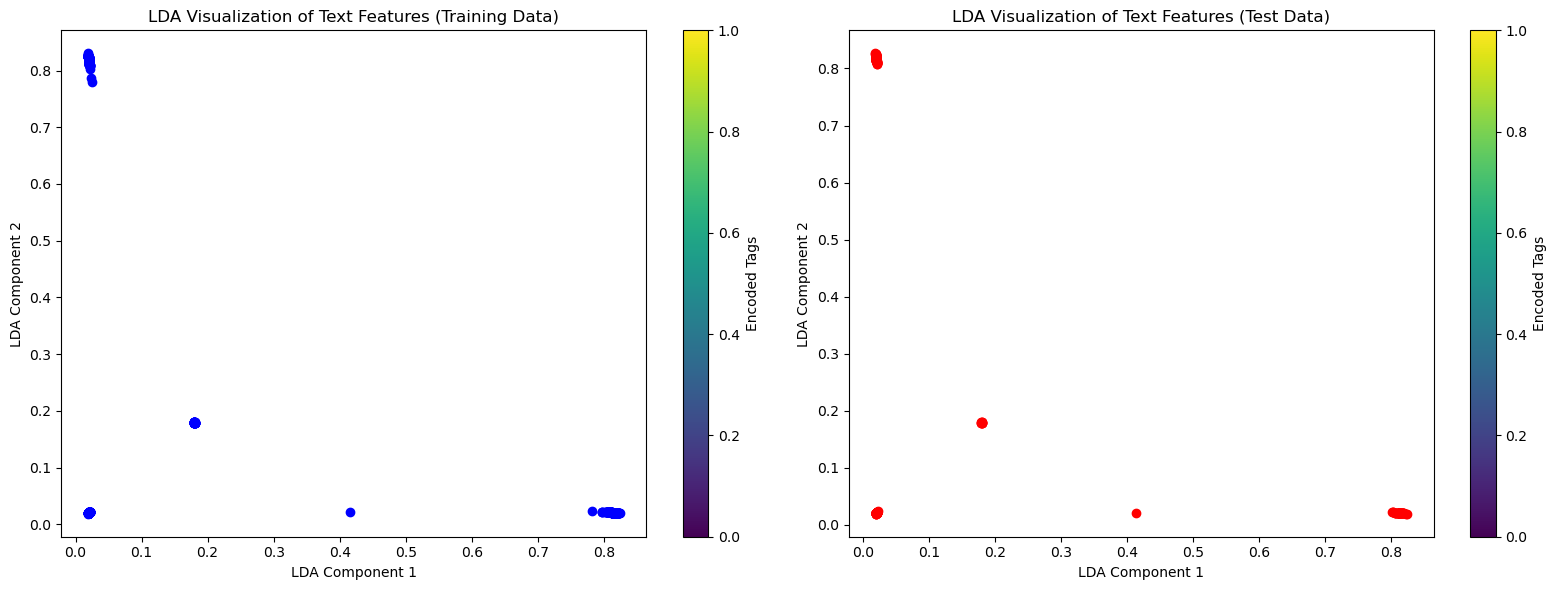

In [43]:
# Création des graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique pour les données d'entraînement
scatter_train = axes[0].scatter(X_lda_2d_train[:, 0], X_lda_2d_train[:, 1], c='blue', cmap='viridis')
axes[0].set_title('LDA Visualization of Text Features (Training Data)')
axes[0].set_xlabel('LDA Component 1')
axes[0].set_ylabel('LDA Component 2')
fig.colorbar(scatter_train, ax=axes[0], label='Encoded Tags')

# Graphique pour les données de test
scatter_test = axes[1].scatter(X_lda_2d_test[:, 0], X_lda_2d_test[:, 1], c='red', cmap='viridis')
axes[1].set_title('LDA Visualization of Text Features (Test Data)')
axes[1].set_xlabel('LDA Component 1')
axes[1].set_ylabel('LDA Component 2')
fig.colorbar(scatter_test, ax=axes[1], label='Encoded Tags')

plt.tight_layout()
plt.show()

- Configuration de l'environnement MLflow


In [210]:
# Identification de l'interface MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Identification du nom du projet MLflow
mlflow.set_experiment("modelExp2")

if mlflow.active_run():
    mlflow.end_run()

- Initiation des modeles

In [211]:
from sklearn.neighbors import KNeighborsClassifier

# Initialisation des modèles
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Dictionnaire des modèles
models = {
    "logistic_regression": logistic_regression,
    "random_forest": random_forest,
    "knn_classifier": knn_classifier, 
    "gradient_boosting": gradient_boosting,
    "svm_classifier": svm_classifier
}

- Évaluation des modèles MultiOutputClassifier

In [212]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
import time

# Dictionnaire pour stocker les résultats des métriques pour chaque modèle
results = {}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        start_time = time.time()  # Pour calculer le temps d'entraînement

        multi_target_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_target_model.fit(X_lda_2d_train, y_train)

        # Prédiction sur les données de test
        y_pred = multi_target_model.predict(X_lda_2d_test)

        # Calcul des métriques d'évaluation
        accuracy = accuracy_score(y_test, y_pred)
        jaccard = jaccard_score(y_test, y_pred, average='samples')
        hamming = hamming_loss(y_test, y_pred)

        # Temps d'exécution
        execution_time = time.time() - start_time

        results[name] = {
            "Accuracy": accuracy,
            "Jaccard Score": jaccard,
            "Hamming Loss": hamming,
            "Execution Time": execution_time
        }

        mlflow.sklearn.log_model(multi_target_model, f"model_{name}")

In [182]:
results_df = pd.DataFrame(results).T

results_df.columns = ["Accuracy", "Jaccard Score", "Hamming Loss", "Execution Time"]
results_df

,Accuracy,Jaccard Score,Hamming Loss,Execution Time
logistic_regression,0.115,0.000000,0.0296,2.266670
random_forest,0.035,0.039917,0.0517,2.893941
knn_classifier,0.105,0.004167,0.0314,0.458149
gradient_boosting,0.040,0.016250,0.0447,5.470056
svm_classifier,0.115,0.000000,0.0296,0.278512


- Prédiction

In [183]:
import mlflow
logged_model = 'runs:/1418f095c87e49caa3f3a8aa188ff390/model_random_forest'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
predictions = loaded_model.predict(pd.DataFrame(X_lda_2d_test))

In [184]:
predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [185]:
predicted_labels = mlb.inverse_transform(predictions)

# Affichage des prédictions pour les 10 premières instances
for i in range(10):
    print(f"Instance {i+1}: {predicted_labels[i]}")

Instance 1: ('sql',)
Instance 2: ('javascript',)
Instance 3: ('php',)
Instance 4: ('c#',)
Instance 5: ('python',)
Instance 6: ()
Instance 7: ('django', 'python')
Instance 8: ('html', 'javascript')
Instance 9: ('java', 'spring-boot')
Instance 10: ('html', 'iphone')


- Performance globale du modèle

In [186]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score


# Calcul de la précision, le rappel et le score F1 pour chaque classe (étiquette)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

jaccard = jaccard_score(y_test, predictions, average='samples')

print("Jaccard Score:", jaccard)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Jaccard Score: 0.041333333333333326
Precision: 0.07569721115537849
Recall: 0.06418918918918919
F1 Score: 0.06946983546617916


#### Commentaire : 

En résumé, les résultats indiquent que votre modèle de classification peut nécessiter des améliorations, en particulier en ce qui concerne la précision et le rappel

# Word/sentence embedding

- BERT

In [101]:
from collections import Counter
all_tags = [tag for sublist in df['Tags'] for tag in sublist]
tag_counts = Counter(all_tags)

In [102]:
top_50_tags = [tag for tag, count in tag_counts.most_common(50)]

In [103]:
def filter_tags(tags):
    return [tag for tag in tags if tag in top_50_tags]

# On filtre pour ne garder que le top 50
df['tags50'] = df['Tags'].apply(filter_tags)

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'mps'

In [105]:
df.shape

(49998, 6)

In [106]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [107]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
encoded_tags = mlb.fit_transform(df['tags50'])

In [108]:
encoded_tags.shape

(49998, 50)

In [109]:
mlb.classes_.shape[0]

50

In [110]:
df_array = pd.DataFrame(encoded_tags, columns=[f'tag_{i}' for i in range(50)])

In [111]:
df_array

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
49994,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49995,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
# On ajoute les encodage de la target à df
df1t = pd.concat([df, df_array], axis=1)

In [113]:
df1 = df1t.sample(n=1000, random_state=42)

In [114]:
df1.shape

(1000, 56)

In [115]:
df1

Title  \
33552                                                             ['intercept', 'mouse', 'click', 'from', 'other', 'program']   
9427                                                             ['akka', 'and', 'state', 'among', 'actors', 'in', 'cluster']   
199    ['keeping', 'the', 'di', 'container', 'usage', 'in', 'the', 'composition', 'root', 'in', 'silverlight', 'and', 'mvvm']   
12447                                                     ['how', 'can', 'i', 'wait', 'for', 'the', 'loop', 'to', 'complete']   
39487                                                         ['how', 'to', 'automate', 'the', 'functional', 'testing', 'in']   
...                                                                                                                       ...   
44743                                                                               ['android', 'webview', 'read', 'cookies']   
46675                                                                               ['log', 'file', 'empty', 'when', 'using']   
12292                                                                     ['bypass', 'css', 'universal', 'selector', 'reset']   
33084                                                             ['how', 'does', 'less', 'command', 'get', 'stdin', 'input']   
13664                                                                   ['oauth', 'callbacks', 'in', 'iphone', 'web', 'apps']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [116]:
df1.text

33552    im trying to intercept mouse clicks from another program im making a plugin for the program that overlays a transparent form on the program and displays additional information when i click on the transparent part of the form i can click on things in the main program i dont want this to happen at least not every time there are some parts where you are allowed to click and some parts where you arent but this isnt the problem the way im doing this now is by using wh_mouse_ll this is working fine and i can keep the mouse click from getting to the program by returning a non zero value http msdn microsoft com en gb library windows desktop v vs aspx the problem is this makes my main program lag i dont need to get notifications for all mouse movements i only want to get a notification if the user actually clicked something is there any way i can limit the wh_mouse_ll so it only fires on mouse clicks the lag isnt because of calculations in the mousehookproc method its currently doing n

In [117]:
# target_cols will be columns resulting from the MultiLabelBinarizer encoding of the tag column 
target_cols = [f'tag_{i}' for i in range(50)]
try:
    print(target_cols)
except NameError:
    print("/!\\ WARNING /!\\")
    print("Ceci est un notebook d'exemple, VOUS DEVEZ DEFINIR target_cols EN FONCTION DU RESULTAT DE VOTRE MULTILABELBINARIZER DANS LE NOTEBOOK DE PREPROCESSING")
    raise NameError("target_cols is not defined")

['tag_0', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15', 'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22', 'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29', 'tag_30', 'tag_31', 'tag_32', 'tag_33', 'tag_34', 'tag_35', 'tag_36', 'tag_37', 'tag_38', 'tag_39', 'tag_40', 'tag_41', 'tag_42', 'tag_43', 'tag_44', 'tag_45', 'tag_46', 'tag_47', 'tag_48', 'tag_49']


In [118]:
from sklearn.model_selection import train_test_split

df_train, temp = train_test_split(df1, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=42)

In [119]:
df_train

Title  \
41567                        ['java', 'printing', 'enlarged', 'printouts', 'on', 'a', 'small', 'number', 'of', 'printers']   
28559                                                 ['how', 'to', 'exclude', 'a', 'specific', 'directory', 'in', 'ncdu']   
22476                                                                  ['unrecognized', 'token', 'was', 'expecting', 'or']   
3493                                                               ['unit', 'test', 'cosmosdb', 'methods', 'using', 'moq']   
30940                                                  ['unique', 'constraint', 'failed', 'sqlite', 'database', 'android']   
...                                                                                                                    ...   
28075                                                                              ['curl', 'f', 'equivalent', 'in', 'c#']   
17820                                                                    ['jit', 'compiler', 'vs', 'offline', 'compilers']   
26037  ['unix', 'command', 'to', 'list', 'files', 'containing', 'string', 'but', 'not', 'containing', 'another', 'string']   
48083             ['cannot', 'open', 'rc', 'file', 'resource', 'explorer', 'cannot', 'load', 'resource', 'load', 'failed']   
29103                                  ['how', 'to', 'identify', 'the', 'missing', 'type', 'id', 'in', 'jackson', 'error']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [120]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

# Encode text
train_encodings = tokenizer(train_dataset['text'], truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_dataset['text'], truncation=True, padding=True, max_length=512)

In [121]:
train_dataset

Dataset({
    features: ['Title', 'Body', 'Tags', 'Text', 'text', 'tags50', 'tag_0', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15', 'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22', 'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29', 'tag_30', 'tag_31', 'tag_32', 'tag_33', 'tag_34', 'tag_35', 'tag_36', 'tag_37', 'tag_38', 'tag_39', 'tag_40', 'tag_41', 'tag_42', 'tag_43', 'tag_44', 'tag_45', 'tag_46', 'tag_47', 'tag_48', 'tag_49', '__index_level_0__'],
    num_rows: 800
})

In [122]:
class BertProcessedDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32).to(device)
            return item

        def __len__(self):
            return len(self.labels)
        
# Convertir les encodages en tenseurs PyTorch
train_dataset = BertProcessedDataset(train_encodings, df_train[target_cols].values)
valid_dataset = BertProcessedDataset(val_encodings, df_val[target_cols].values)

In [134]:
model = AutoModelForSequenceClassification.from_pretrained(
    r"C:\Users\amous\OneDrive\Documents\bert_model_exemple", 
    num_labels=mlb.classes_.shape[0], 
    problem_type="multi_label_classification"
)
model.to(device);

In [135]:
pickle.dump(model, open('model.pkl', 'wb'))


In [124]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    final_metrics = {}
    
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1  
    
    final_metrics["f1_micro"] = f1_score(labels, predictions, average="micro")
    final_metrics["f1_macro"] = f1_score(labels, predictions, average="macro")
    final_metrics["f1_weighted"] = f1_score(labels, predictions, average="weighted")
    
    return final_metrics

In [125]:
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(f"./{now}-bert-model", exist_ok=True)

In [126]:
# Définissons quelques variables clés qui seront utilisées plus tard dans la formation
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 2e-5

In [127]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir = f"./{now}-bert-model",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,
    eval_accumulation_steps=50,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.03)],
)

C:\Users\amous\anaconda3\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted
1,0.055500,0.049320,0.651515,0.416760,0.605078
2,0.035900,0.051441,0.646552,0.351371,0.567312
3,0.028100,0.050858,0.656489,0.403933,0.609816
4,0.018500,0.052628,0.669145,0.442342,0.623993


TrainOutput(global_step=3200, training_loss=0.03368144012987614, metrics={'train_runtime': 21444.5792, 'train_samples_per_second': 0.373, 'train_steps_per_second': 0.373, 'total_flos': 842318236876800.0, 'train_loss': 0.03368144012987614, 'epoch': 4.0})

Commentaire 

Les scores augmente globalement à chaque époque, ce qui suggère que le modèle s'améliore dans sa capacité à prédire correctement les Tags.
Le modèle s'améliore au fil des époques en termes de performances et semble bien généraliser sur les données de validation.

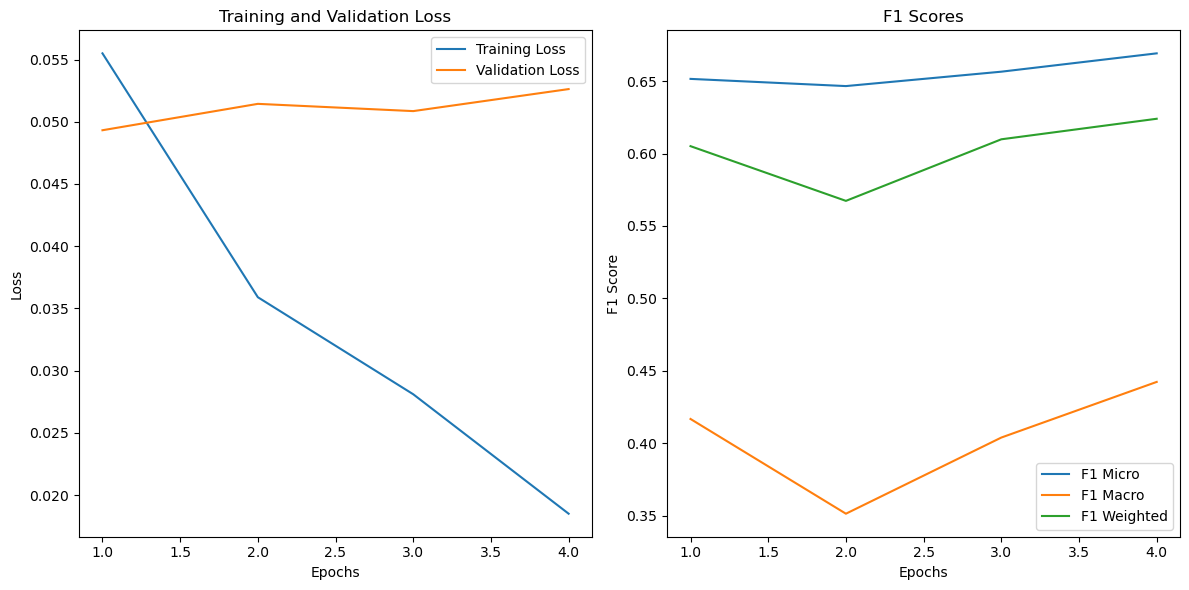

In [41]:
import matplotlib.pyplot as plt

# Données d'exemple
epochs = [1, 2, 3, 4]
training_loss = [0.055500, 0.035900, 0.028100, 0.018500]
validation_loss = [0.049320, 0.051441, 0.050858, 0.052628]
f1_micro = [0.651515, 0.646552, 0.656489, 0.669145]
f1_macro = [0.416760, 0.351371, 0.403933, 0.442342]
f1_weighted = [0.605078, 0.567312, 0.609816, 0.623993]
# Tracer les courbes
plt.figure(figsize=(12, 6))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Courbes de performance
plt.subplot(1, 2, 2)
plt.plot(epochs, f1_micro, label='F1 Micro')
plt.plot(epochs, f1_macro, label='F1 Macro')
plt.plot(epochs, f1_weighted, label='F1 Weighted')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Scores')
plt.legend()

plt.tight_layout()
plt.show()

Commentaire :  En résumé, les résultats d'évaluation montrent que le modèle a des performances globalement acceptables

In [42]:
trainer.evaluate()

{'eval_loss': 0.05262819677591324,
 'eval_f1_micro': 0.6691449814126395,
 'eval_f1_macro': 0.4423424908424908,
 'eval_f1_weighted': 0.6239933375802942,
 'eval_runtime': 196.2725,
 'eval_samples_per_second': 0.509,
 'eval_steps_per_second': 0.509,
 'epoch': 4.0}

In [43]:
test_dataset = Dataset.from_pandas(df_test)
test_encodings = tokenizer(test_dataset['text'], truncation=True, padding=True, max_length=512)

test_labels = df_test[target_cols].values
test_dataset = BertProcessedDataset(test_encodings, test_labels)

In [44]:
pred_opts = trainer.predict(test_dataset)

In [45]:
pred_opts.metrics

{'test_loss': 0.06306822597980499,
 'test_f1_micro': 0.6557377049180327,
 'test_f1_macro': 0.5473058286742498,
 'test_f1_weighted': 0.6169570434714428,
 'test_runtime': 196.4438,
 'test_samples_per_second': 0.509,
 'test_steps_per_second': 0.509}

In [ ]:
#pip install torch torchvision torchaudio

In [ ]:
#pip install tensorflow

In [ ]:
#pip install torch torchvision torchaudio


In [46]:
import torch
torch.cuda.is_available()

False

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [48]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [132]:
model_path = r"C:\Users\amous\OneDrive\Documents\bert_model_exemple"

# Choix automatique du device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
print(device)

cpu


In [133]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    model_path
)
model.to(device);

In [51]:
from transformers import TextClassificationPipeline
pipe = TextClassificationPipeline(
    model=model, 
    tokenizer=tokenizer, 
    return_all_scores=False, 
    device=device,
    task="multi_label_classification",
    function_to_apply='sigmoid'
)

In [52]:
example_text = 'i read in tcp ip network administration by o that typing the route n command should bring up a routing table when i typed it into the terminal on a mac it returned the following usage route dnqtv command modifiers args what is the correct command to use to see the routing table in my terminal'

In [53]:
# Apparence des resultats du pipe
pipe(example_text)

[{'label': 'macos', 'score': 0.7781149744987488}]

In [54]:
%%time
# Apparence des resultats du pipe lorsque l'on demande 5 reponses
pipe('how do i install python on arch linux ? i cant understand the docs', top_k=5)

CPU times: total: 156 ms
Wall time: 89.6 ms


[{'label': 'python', 'score': 0.8857898712158203},
 {'label': 'linux', 'score': 0.595388650894165},
 {'label': 'python-3.x', 'score': 0.12746413052082062},
 {'label': 'windows', 'score': 0.05369570851325989},
 {'label': 'macos', 'score': 0.016154713928699493}]

- Wrapper qui recommandera les resultats les plus pertinents

In [55]:
def pred_fn(text, pipeline, thresh=0.5, max_answers=10):
    pipe_output = pipeline(text, top_k=max_answers)
    recommended_tags = [
        dict_output['label'] for dict_output in pipe_output if dict_output['score'] > thresh
    ]
    
    return recommended_tags

In [56]:
pred_fn('how do i install python on arch linux ? i cant understand the docs', pipe)

['python', 'linux']

In [57]:
pred_fn(example_text, pipe)

['macos']

- Deploiyement 

- Performaence globale du modele

In [76]:
test_dataset = Dataset.from_pandas(df_test)
test_encodings = tokenizer(test_dataset['text'], truncation=True, padding=True, max_length=512)

test_labels = df_test[target_cols].values
test_dataset = BertProcessedDataset(test_encodings, test_labels)

In [79]:
model.eval()

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

y_test = []

for batch in test_dataloader:
    y_test_batch = batch['labels'].cpu().numpy().tolist()
    y_test.extend(y_test_batch)

y_test = np.array(y_test)

In [82]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

precision = precision_score(y_test, binary_predictions, average='samples')
recall = recall_score(y_test, binary_predictions, average='samples')
f1 = f1_score(y_test, binary_predictions, average='samples')
jaccard = jaccard_score(y_test, binary_predictions, average='samples')

print("Jaccard Score:", jaccard)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Jaccard Score: 0.5536666666666666
Precision: 0.6766666666666667
Recall: 0.6075
F1 Score: 0.6093333333333333


# Word2Vec

In [163]:
pip install scikit-learn==1.3.0


Note: you may need to restart the kernel to use updated packages.


In [164]:
!pip install transformers


In [179]:
import tensorflow as tf
#import tensorflow_hub as hub

In [167]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss

import mlflow
import time

In [168]:
# Création des modèles
logistic_regression = LogisticRegression()
svc_classifier = SVC()
gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Dictionnaire des modèles
models = {
    "logistic_regression": logistic_regression,
    "svc_classifier": svc_classifier,
    "gradient_boosting": gradient_boosting,
    "random_forest": random_forest
}


- Séparation des données


In [193]:
X_train, X_test, y_train, y_test = train_test_split(filtered_data['Text'], encoded_tags, test_size=0.2, random_state=42)


- Entraînement du modèle Word2Vec


In [194]:
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, min_count=1)

# Extraction des caractéristiques Word2Vec
word2vec_features_train = []
for text in X_train:
    words = text.split()
    valid_words = [word for word in words if word in word2vec_model.wv]
    if valid_words:
        word2vec_features_train.append(np.mean([word2vec_model.wv[word] for word in valid_words], axis=0))
    else:
        word2vec_features_train.append(np.zeros(word2vec_model.vector_size))

word2vec_features_test = []
for text in X_test:
    words = text.split()
    valid_words = [word for word in words if word in word2vec_model.wv]
    if valid_words:
        word2vec_features_test.append(np.mean([word2vec_model.wv[word] for word in valid_words], axis=0))
    else:
        word2vec_features_test.append(np.zeros(word2vec_model.vector_size))

-  Entraînement et évaluation du modèle Gradient Boosting

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
from sklearn.multioutput import MultiOutputClassifier
import mlflow

random_forest = RandomForestClassifier()
random_forest = MultiOutputClassifier(random_forest)

with mlflow.start_run():
    random_forest.fit(word2vec_features_train, y_train)

    random_forest_pred = random_forest.predict(word2vec_features_test)

    accuracy_random_forest = accuracy_score(y_test, random_forest_pred)
    jaccard_random_forest = jaccard_score(y_test, random_forest_pred, average='samples')
    hamming_loss_random_forest = hamming_loss(y_test, random_forest_pred)

    mlflow.log_metric("accuracy_random_forest", accuracy_random_forest)
    mlflow.log_metric("jaccard_random_forest", jaccard_random_forest)
    mlflow.log_metric("hamming_loss_random_forest", hamming_loss_random_forest)

    mlflow.sklearn.log_model(random_forest, "random_forest_model")

- Prédiction

In [196]:
import mlflow
logged_model = 'runs:/82d2b9abf7b84b949c019c1e281ccc4c/random_forest_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
predictions1 = loaded_model.predict(pd.DataFrame(word2vec_features_test))

In [197]:
predicted_labels1 = mlb.inverse_transform(predictions1)

for i in range(10):
    print(f"Instance {i+1}: {predicted_labels1[i]}")

Instance 1: ()
Instance 2: ()
Instance 3: ('java',)
Instance 4: ()
Instance 5: ()
Instance 6: ()
Instance 7: ('java',)
Instance 8: ()
Instance 9: ()
Instance 10: ()


- Performance globale du modèle

In [198]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score


# Calculer la précision, le rappel et le score F1 pour chaque classe (étiquette)
precision = precision_score(y_test, predictions1, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions1, average='micro')

jaccard = jaccard_score(y_test, predictions1, average='samples')

print("Jaccard Score:", jaccard)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Jaccard Score: 0.03083333333333333
Precision: 0.42857142857142855
Recall: 0.06418918918918919
F1 Score: 0.0906344410876133


#  USE (Universal Sentence Encoder)

In [29]:
#pip install tensorflow


In [30]:
#pip install --upgrade tensorflow-hub

In [31]:
#pip install tensorflow-hub


In [188]:
import tensorflow as tf
import tensorflow_hub as hub

In [189]:
# Chargement du module USE (Universal Sentence Encoder)
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Extraction des caractéristiques USE
use_features = [use_embed([text])[0].numpy() for text in filtered_data['Text']]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
import time
import mlflow
from mlflow.sklearn import log_model

# Création du modèle Random Forest
random_forest = RandomForestClassifier()

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(use_features, encoded_tags, test_size=0.2, random_state=42)

- Evaluation du modèle

In [29]:
def train_and_evaluate_model(model, features_train, features_test, tags_train, tags_test, name):
    with mlflow.start_run(run_name=name):
        start_time = time.time()

        model.fit(features_train, tags_train)

        y_pred = model.predict(features_test)

        accuracy = accuracy_score(tags_test, y_pred)
        jaccard = jaccard_score(tags_test, y_pred, average='samples')
        hamming = hamming_loss(tags_test, y_pred)

        execution_time = time.time() - start_time

        # Enregistrement des résultats dans MLflow
        mlflow.log_params({"Model": name})
        mlflow.log_metrics({"Accuracy": accuracy, "Jaccard Score": jaccard, "Hamming Loss": hamming, "Execution Time": execution_time})
        mlflow.sklearn.log_model(model, f"model_{name}")

random_forest = RandomForestClassifier()

mlflow.end_run() 
train_and_evaluate_model(random_forest, X_train, X_test, y_train, y_test, "RandomForest_USE")

- Prédiction

In [30]:
import mlflow
logged_model = 'runs:/e89886bb809b4a81944692585c84bbd2/model_RandomForest_USE'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

predictionsUSE = loaded_model.predict(pd.DataFrame(use_features))

In [31]:
# Convertir les prédictions en labels de texte
predicted_labels_USE = mlb.inverse_transform(predictionsUSE)

# Afficher les prédictions pour les 10 premières instances
for i in range(10):
    print(f"Instance {i+1}: {predicted_labels_USE[i]}")

Instance 1: ('.net', 'c#')
Instance 2: ()
Instance 3: ('c#',)
Instance 4: ('asynchronous', 'javascript', 'node.js')
Instance 5: ('php',)
Instance 6: ('android',)
Instance 7: ('.net', 'c#', 'xml')
Instance 8: ('iphone', 'xcode')
Instance 9: ('hibernate', 'java', 'jpa')
Instance 10: ('ios',)


- Performance globale du modèle 

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

predicted_labels_USE = mlb.inverse_transform(predictionsUSE)

flattened_predictions = mlb.transform(predicted_labels_USE)

num_samples = min(len(y_test), len(flattened_predictions))
y_test_subset = y_test[:num_samples]
predictions_subset = flattened_predictions[:num_samples]
precision = precision_score(y_test_subset, predictions_subset, average='micro')
recall = recall_score(y_test_subset, predictions_subset, average='micro')
f1 = f1_score(y_test_subset, predictions_subset, average='micro')

jaccard = jaccard_score(y_test_subset, predictions_subset, average='samples')

print("Jaccard Score:", jaccard)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Jaccard Score: 0.0385
Precision: 0.05660377358490566
Recall: 0.05067567567567568
F1 Score: 0.05347593582887701


# Conclusion:

Nous avons effectué une analyse comparative des performances de différentes approches pour la classification de texte, en utilisant des modèles supervisés tels que Bag-of-Words, Word2Vec, USE et BERT, ainsi que des approches non supervisées telles que TF-IDF et NMF.

Pour les approches supervisées, nous avons calculé plusieurs métriques d'évaluation, y compris le Jaccard Score, la Précision, le Rappel et le F1 Score. Les résultats montrent que BERT donne une performance élévé, avec un Jaccard Score de 0.55 et des scores de Précision (0.61) et de F1 Score de 0.6093 comparativement au Word2Vec et Use.

Pour les approches non supervisées, nous avons évalué la cohérence des modèles TF-IDF et NMF. Les résultats montrent que le modèle NMF a une cohérence plus élevée avec un score de 0.6178, tandis que le modèle TF-IDF a un score de 0.5195.

En résumé, nos résultats indiquent que BERT offre de bonnes performance pour la classification de texte, mais peuvent être sensibles à la taille et à la qualité des données d'entraînement. 

Les sorties représentent les prédictions de BERT sur les sujets ou les domaines couverts par chaque question, ce qui peut être utilisé pour organiser, indexer et recommander des questions sur des plateformes comme Stack Overflow.